# 

# Lasso problem


The lasso problem is:

$$ L_{n,\delta} :=\min_{\beta} \frac{1}{2n}|| y - X \beta ||^2_2 $$
$$ \text{S.t} ||\beta||_1 \leq \delta$$

or:

$$ L_{n,\delta} :=\min_{\beta} \frac{1}{2n}|| y - X \beta ||^2_2 + \alpha ||\beta||_1 $$

The objective of this notebook is Compare Lasso, R-FS and Path R-FS profile coeficients and solutions.

## Toy Datasets

We start with a toy dataset. And a value of $\delta = 1$


In [5]:
import numpy as np
import pandas as pd
from boosting import Boosting 
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, LinearRegression

In [7]:
n, p = 50 ,10 #number of samples and features
rho = 0.5
sigma= 1.0

#generate covariance matrix
Sigma = rho ** np.abs(np.subtract.outer(np.arange(p), np.arange(p)))
X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

#standardize X
X -= X.mean(axis=0)
X /= np.linalg.norm(X, axis=0)


beta_true = np.array([2.0, -1.5, 5.0, 1.0, 1.0, 2.0, 7.0, 8.0, 1.0, -1.0])
y = X @ beta_true + sigma * np.random.randn(n)

data = pd.DataFrame(X, columns =[f"X{i+1}" for i in range(p)])
data["y"] = y

verify correlations betewn variables

In [8]:
data.corr().round(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
X1,1.00,0.53,0.34,0.27,0.14,-0.05,0.15,0.07,0.06,0.06,0.31
X2,0.53,1.00,0.50,0.17,0.22,0.05,0.16,0.13,0.03,0.01,0.31
X3,0.34,0.50,1.00,0.47,0.39,0.11,0.02,0.06,-0.05,-0.05,0.41
X4,0.27,0.17,0.47,1.00,0.48,0.26,0.02,-0.10,-0.01,-0.09,0.22
X5,0.14,0.22,0.39,0.48,1.00,0.57,0.03,-0.18,0.03,-0.00,0.16
X6,-0.05,0.05,0.11,0.26,0.57,1.00,0.43,0.16,0.12,0.08,0.46
X7,0.15,0.16,0.02,0.02,0.03,0.43,1.00,0.62,0.50,0.32,0.79
X8,0.07,0.13,0.06,-0.10,-0.18,0.16,0.62,1.00,0.70,0.45,0.75
X9,0.06,0.03,-0.05,-0.01,0.03,0.12,0.50,0.70,1.00,0.62,0.51
X10,0.06,0.01,-0.05,-0.09,-0.00,0.08,0.32,0.45,0.62,1.00,0.25


### Laso path

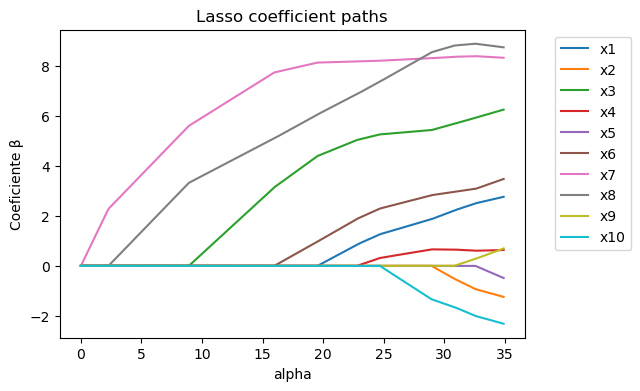

In [9]:
alphas, coefs, _ = lasso_path(X, y, n_alphas=1000)
from sklearn.linear_model import Lasso

plt.figure(figsize=(6,4))
bnorms = [np.linalg.norm(coefs[:, i], 1) for i in range(coefs.shape[1])]

for i in range(p):
    plt.plot(bnorms, coefs[i, :], label=f"x{i+1}")
plt.xlabel("alpha")
plt.ylabel("Coeficiente β")
plt.title("Lasso coefficient paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### R_FS 

In [10]:
exp = Boosting(X,y)

deltas = [1/alpha for alpha in alphas]

In [17]:
solutions = []
exp = Boosting(X,y)
for delta in deltas:
    solutions.append(exp.R_FS(delta=delta, numiter=1000))
    if len(solutions) % 150 == 0:
        print(f"Completed {len(solutions)} out of {len(deltas)}, completed {(len(solutions)/len(deltas))*100:.2f}%")

Completed 150 out of 1000, completed 15.00%
Completed 300 out of 1000, completed 30.00%
Completed 450 out of 1000, completed 45.00%
Completed 600 out of 1000, completed 60.00%
Completed 750 out of 1000, completed 75.00%
Completed 900 out of 1000, completed 90.00%


### Path R-FS

In [18]:
solutions1 = []

numiter=1000
deltalist = list(np.linspace(1, 10000, numiter+1))


for delta in deltas:
    solutions1.append(exp.Path_R_FS(numiter= numiter,
                                    epsilon=min(deltalist)/2,
                                    delta_list= deltalist))
    if len(solutions1) % 150 == 0:
        print(f"Completed {len(solutions1)} out of {len(deltas)}, completed {(len(solutions1)/len(deltas))*100:.2f}%")

Completed 150 out of 1000, completed 15.00%
Completed 300 out of 1000, completed 30.00%
Completed 450 out of 1000, completed 45.00%
Completed 600 out of 1000, completed 60.00%
Completed 750 out of 1000, completed 75.00%
Completed 900 out of 1000, completed 90.00%


### Comparation

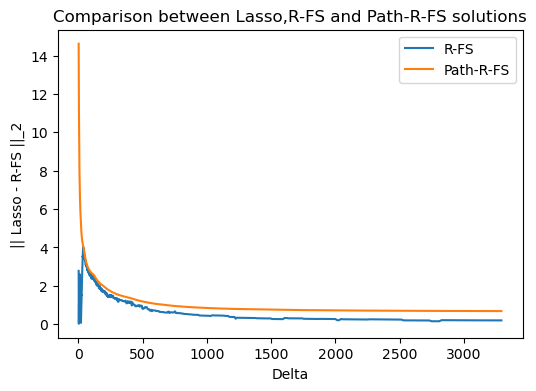

In [19]:
comp1 = [np.linalg.norm(coefs[:, i] - solutions1[i], 2) for i in range(len(solutions1))]
comp = [np.linalg.norm(coefs[:, i] - solutions[i], 2) for i in range(len(solutions))]

plt.figure(figsize=(6,4))
plt.plot(deltas, comp)
plt.plot(deltas, comp1)
plt.xlabel("Delta")
plt.ylabel("|| Lasso - R-FS ||_2")
plt.title("Comparison between Lasso,R-FS and Path-R-FS solutions")
plt.legend(["R-FS", "Path-R-FS"], loc='upper right')
plt.show()

# Prostate dataset

In [20]:
url = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = pd.read_csv(url, sep="\t")
X = df.drop(columns=["lpsa", "train","Unnamed: 0"]).values
y = df["lpsa"].values

In [21]:
def normalize_data(data,responses):
    y = responses - np.mean(responses)
    X = data - np.mean(data, axis=0)
    X = X / np.linalg.norm(X, axis=0)
    return X, y

X, y = normalize_data(X, y)

## Lasso

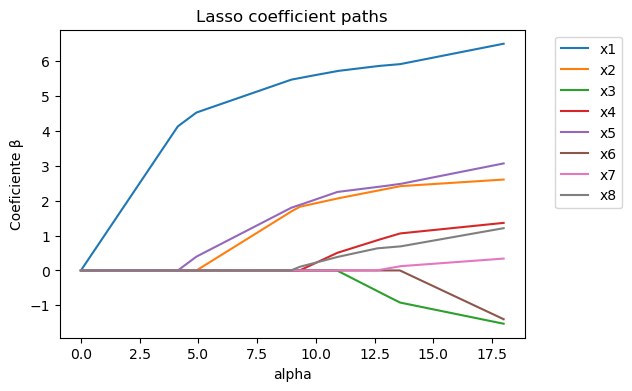

In [22]:
alphas, coefs, _ = lasso_path(X, y, n_alphas=1000)
from sklearn.linear_model import Lasso

plt.figure(figsize=(6,4))
bnorms = [np.linalg.norm(coefs[:, i], 1) for i in range(coefs.shape[1])]

for i in range(coefs.shape[0]):
    plt.plot(bnorms, coefs[i, :], label=f"x{i+1}")
plt.xlabel("alpha")
plt.ylabel("Coeficiente β")
plt.title("Lasso coefficient paths")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### R-FS

In [23]:
deltas = [1/alpha for alpha in alphas]

In [25]:
solutions = []
exp = Boosting(X,y)
for delta in deltas:
    solutions.append(exp.R_FS(delta=delta, numiter=10000))
    if len(solutions) % 150 == 0:
        print(f"Completed {len(solutions)} out of {len(deltas)}, completed {(len(solutions)/len(deltas))*100:.2f}%")

Completed 150 out of 1000, completed 15.00%
Completed 300 out of 1000, completed 30.00%
Completed 450 out of 1000, completed 45.00%
Completed 600 out of 1000, completed 60.00%
Completed 750 out of 1000, completed 75.00%
Completed 900 out of 1000, completed 90.00%


### Path-R-FS

In [26]:
solutions1 = []

numiter=10000
deltalist = list(np.linspace(1, 10000, numiter+1))


for delta in deltas:
    solutions1.append(exp.Path_R_FS(numiter= numiter,
                                    epsilon=min(deltalist)/2,
                                    delta_list= deltalist))
    if len(solutions1) % 150 == 0:
        print(f"Completed {len(solutions1)} out of {len(deltas)}, completed {(len(solutions1)/len(deltas))*100:.2f}%")

Completed 150 out of 1000, completed 15.00%
Completed 300 out of 1000, completed 30.00%
Completed 450 out of 1000, completed 45.00%
Completed 600 out of 1000, completed 60.00%
Completed 750 out of 1000, completed 75.00%
Completed 900 out of 1000, completed 90.00%


### Comparation

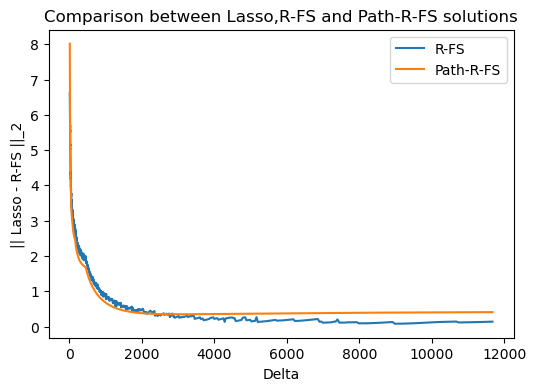

In [27]:
comp1 = [np.linalg.norm(coefs[:, i] - solutions1[i], 2) for i in range(len(solutions1))]
comp = [np.linalg.norm(coefs[:, i] - solutions[i], 2) for i in range(len(solutions))]

plt.figure(figsize=(6,4))
plt.plot(deltas, comp)
plt.plot(deltas, comp1)
plt.xlabel("Delta")
plt.ylabel("|| Lasso - R-FS ||_2")
plt.title("Comparison between Lasso,R-FS and Path-R-FS solutions")
plt.legend(["R-FS", "Path-R-FS"], loc='upper right')
plt.show()